# Data Processing

In this notebook, we will prepare the dataset for modeling.  

In [61]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# I. Data daily

In [62]:
# Load the dataset
df_daily = pd.read_excel(r'../data/processed/data_daily_after_basic_understand.xlsx')

In [63]:
# Xác định loại dữ liệu
numerical_features = df_daily.select_dtypes(include=['float64', 'int64']).columns.tolist()
categorical_features = df_daily.select_dtypes(include=['object']).columns.tolist()

print("Numeric features:", numerical_features)
print("Categorical features:", categorical_features)

Numeric features: ['tempmax', 'tempmin', 'temp', 'feelslikemax', 'feelslikemin', 'feelslike', 'dew', 'humidity', 'precip', 'precipcover', 'windgust', 'windspeed', 'winddir', 'sealevelpressure', 'cloudcover', 'visibility', 'solarradiation', 'solarenergy', 'uvindex', 'severerisk', 'moonphase']
Categorical features: ['conditions', 'description', 'icon', 'stations']


In [64]:
df_daily['datetime'] = pd.to_datetime(df_daily['datetime'])
df_daily = df_daily.sort_values('datetime').reset_index(drop=True)

In [65]:
# Chia train-test split theo thời gian, trong đó khoảng cách tập train và test là 7 ngày để tránh data leakage do tính chất thời gian của dữ liệu, temp là biến mục tiêu
train_size = int(len(df_daily) * 0.8)
# Tập huấn luyện kết thúc trước 7 ngày so với tập kiểm tra
train_data = df_daily.iloc[:train_size - 7] 
# Tập kiểm tra bắt đầu từ ngày thứ 7 sau tập huấn luyện đến hết
test_data = df_daily.iloc[train_size:]
print(f"Kích thước tập huấn luyện: {train_data.shape}")
print(f"Kích thước tập kiểm tra: {test_data.shape}")
print(f"Khoảng thời gian tập huấn luyện: {train_data['datetime'].min()} đến {train_data['datetime'].max()}")
print(f"Khoảng thời gian tập kiểm tra: {test_data['datetime'].min()} đến {test_data['datetime'].max()}")

# temp là biến mục tiêu
feature_cols = df_daily.columns.drop(['temp', 'datetime'])  # Loại bỏ cột temp khỏi features
X_train = train_data[feature_cols]
y_train = train_data['temp']
X_test = test_data[feature_cols]
y_test = test_data['temp']

print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

Kích thước tập huấn luyện: (3134, 28)
Kích thước tập kiểm tra: (786, 28)
Khoảng thời gian tập huấn luyện: 2015-01-01 00:00:00 đến 2023-07-31 00:00:00
Khoảng thời gian tập kiểm tra: 2023-08-08 00:00:00 đến 2025-10-01 00:00:00
X_train shape: (3134, 26), y_train shape: (3134,)
X_test shape: (786, 26), y_test shape: (786,)


In [66]:
# Kiểm tra missing values và duplicates
print("Số lượng giá trị thiếu:\n", df_daily.isnull().sum())
print("\nTỷ lệ thiếu (%):\n", (df_daily.isnull().mean() * 100).round(2))

dupes_daily = df_daily.duplicated().sum()
print(f"\nSố dòng trùng lặp: {dupes_daily}")

Số lượng giá trị thiếu:
 datetime               0
tempmax                0
tempmin                0
temp                   0
feelslikemax           0
feelslikemin           0
feelslike              0
dew                    0
humidity               0
precip                 0
precipcover            0
windgust               0
windspeed              0
winddir                0
sealevelpressure       0
cloudcover             0
visibility             0
solarradiation         0
solarenergy            0
uvindex                0
severerisk          2566
sunrise                0
sunset                 0
moonphase              0
conditions             0
description            0
icon                   0
stations               0
dtype: int64

Tỷ lệ thiếu (%):
 datetime             0.00
tempmax              0.00
tempmin              0.00
temp                 0.00
feelslikemax         0.00
feelslikemin         0.00
feelslike            0.00
dew                  0.00
humidity             0.00
precip   

In [67]:
# Xử lý missing values cho từng tập

In [68]:
# Phát hiện outliers bằng phương pháp IQR
numeric_cols_d = df_daily.select_dtypes(include=[np.number]).columns

Q1_d = df_daily[numeric_cols_d].quantile(0.25)
Q3_d = df_daily[numeric_cols_d].quantile(0.75)
IQR_d = Q3_d - Q1_d

outliers_d = ((df_daily[numeric_cols_d] < (Q1_d - 1.5 * IQR_d)) | 
              (df_daily[numeric_cols_d] > (Q3_d + 1.5 * IQR_d))).sum()

print("Số lượng outliers (theo từng cột):\n", outliers_d)

Số lượng outliers (theo từng cột):
 tempmax               3
tempmin               1
temp                  2
feelslikemax          0
feelslikemin         20
feelslike             0
dew                  41
humidity             91
precip              639
precipcover         169
windgust            117
windspeed            59
winddir             664
sealevelpressure      1
cloudcover            0
visibility          119
solarradiation        0
solarenergy           0
uvindex               0
severerisk            0
moonphase             0
dtype: int64


In [69]:
# Xử lý outliers  cho từng tập
def cap_outliers_iqr(df):
    df_capped = df.copy()
    numeric_cols = df_capped.select_dtypes(include=[np.number]).columns

    for col in numeric_cols:
        Q1 = df_capped[col].quantile(0.25)
        Q3 = df_capped[col].quantile(0.75)
        IQR = Q3 - Q1
        lower = Q1 - 1.5 * IQR
        upper = Q3 + 1.5 * IQR
        df_capped[col] = np.where(df_capped[col] < lower, lower,
                                  np.where(df_capped[col] > upper, upper, df_capped[col]))
    return df_capped


# Áp dụng cho từng tập
X_train_capped = cap_outliers_iqr(X_train)
X_test_capped = cap_outliers_iqr(X_test)

print(f"Train shape: {X_train_capped.shape}, Test shape: {X_test_capped.shape}")



Train shape: (3134, 26), Test shape: (786, 26)


In [70]:
# Kiểm tra lại số lượng outliers sau khi xử lý theo IQR
def count_outliers_iqr(df):
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    Q1 = df[numeric_cols].quantile(0.25)
    Q3 = df[numeric_cols].quantile(0.75)
    IQR = Q3 - Q1
    outliers = ((df[numeric_cols] < (Q1 - 1.5 * IQR)) | 
                (df[numeric_cols] > (Q3 + 1.5 * IQR))).sum()
    return outliers

# Đếm outliers sau xử lý
outliers_train_after = count_outliers_iqr(X_train_capped)
outliers_test_after = count_outliers_iqr(X_test_capped)

print("Số lượng outliers trong tập TRAIN sau xử lý:")
print(outliers_train_after[outliers_train_after > 0])

print("\nSố lượng outliers trong tập TEST sau xử lý:")
print(outliers_test_after[outliers_test_after > 0])


Số lượng outliers trong tập TRAIN sau xử lý:
Series([], dtype: int64)

Số lượng outliers trong tập TEST sau xử lý:
Series([], dtype: int64)


In [71]:
# So sánh trước và sau xử lý
outliers_before = count_outliers_iqr(X_train)
outliers_after = count_outliers_iqr(X_train_capped)

compare = pd.DataFrame({
    'Before': outliers_before,
    'After': outliers_after
})
print(compare[compare['Before'] > 0])


                  Before  After
tempmax                2      0
tempmin                1      0
feelslikemin          19      0
dew                   30      0
humidity              65      0
precip               523      0
precipcover          118      0
windgust              91      0
windspeed             40      0
winddir              523      0
sealevelpressure       2      0
cloudcover            33      0
visibility            87      0


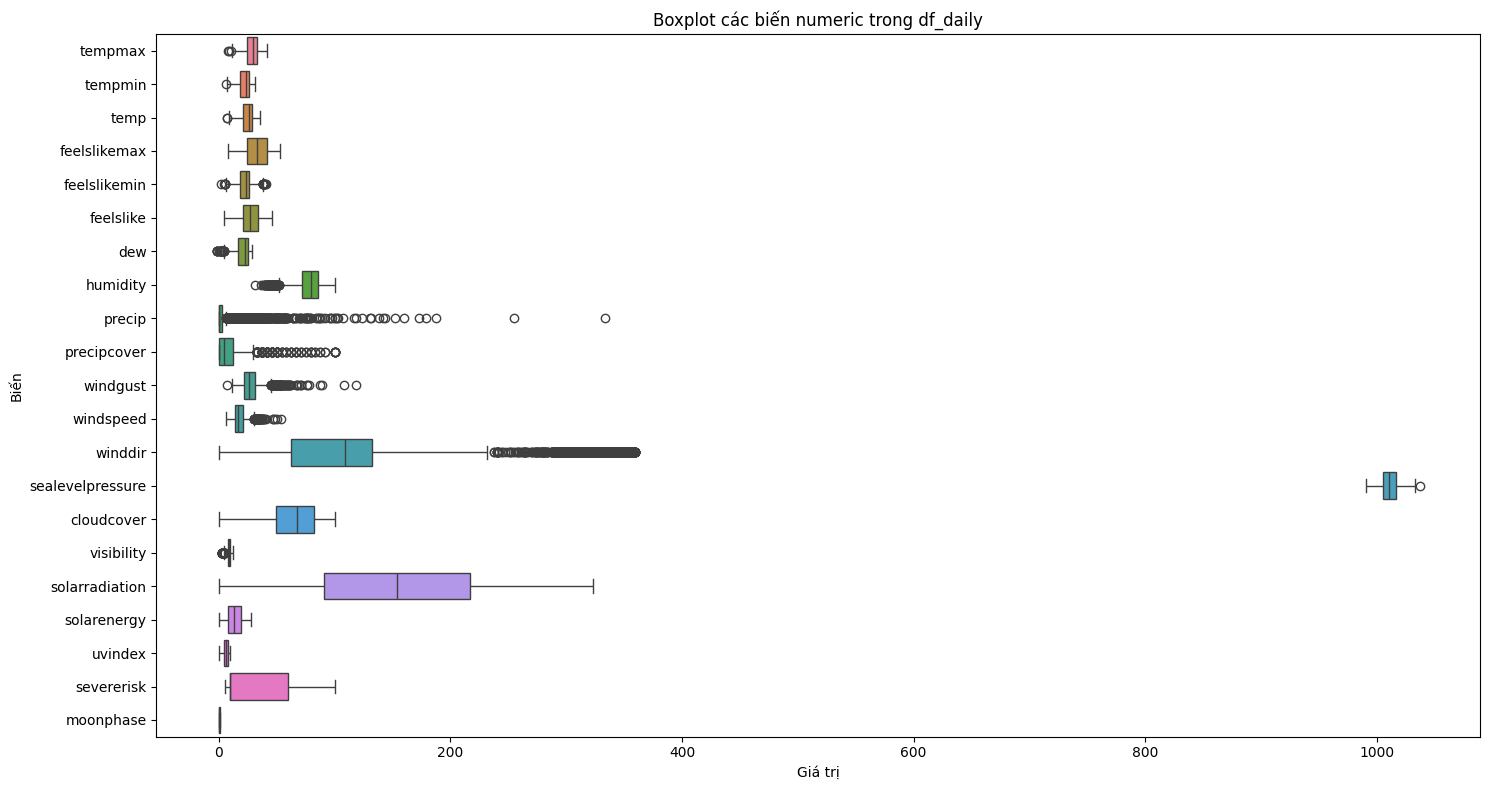

In [72]:
numeric_cols_d = df_daily.select_dtypes(include=['number']).columns

# Vẽ boxplot
plt.figure(figsize=(15, 8))
sns.boxplot(data=df_daily[numeric_cols_d], orient='h', showfliers=True)
plt.title("Boxplot các biến numeric trong df_daily")
plt.xlabel("Giá trị")
plt.ylabel("Biến")
plt.tight_layout()
plt.show()

In [73]:
# Ma trận tương quan
corr = df_daily.corr(numeric_only=True)
print(corr)

                   tempmax   tempmin      temp  feelslikemax  feelslikemin  \
tempmax           1.000000  0.909259  0.977722      0.964647      0.889029   
tempmin           0.909259  1.000000  0.969581      0.910259      0.963060   
temp              0.977722  0.969581  1.000000      0.957785      0.942461   
feelslikemax      0.964647  0.910259  0.957785      1.000000      0.899939   
feelslikemin      0.889029  0.963060  0.942461      0.899939      1.000000   
feelslike         0.954692  0.942145  0.974478      0.979062      0.951898   
dew               0.843814  0.932995  0.902911      0.866739      0.872035   
humidity          0.011194  0.226346  0.100473      0.097697      0.140572   
precip            0.056500  0.130930  0.090129      0.099973      0.079126   
precipcover       0.061395  0.170696  0.106710      0.094612      0.124118   
windgust          0.126321  0.144815  0.135714      0.119640      0.116548   
windspeed         0.155296  0.155355  0.153572      0.181514    

In [74]:
# Chuẩn hóa

In [75]:
# Xử lý text

In [76]:
# Save the processed data
save_dir = '../data/processed/'

X_train_capped.to_excel(save_dir + 'X_train.xlsx', index=False)
y_train.to_excel(save_dir + 'y_train.xlsx', index=False)
X_test_capped.to_excel(save_dir + 'X_test.xlsx', index=False)
y_test.to_excel(save_dir + 'y_test.xlsx', index=False)

# II. Data hourly

In [77]:
# Load the dataset
df_hourly = pd.read_excel(r'../data/processed/data_hourly_after_basic_understand.xlsx')

In [78]:
# Xác định loại dữ liệu
numerical_features = df_hourly.select_dtypes(include=['float64', 'int64']).columns.tolist()
categorical_features = df_hourly.select_dtypes(include=['object']).columns.tolist()

print("Numeric features:", numerical_features)
print("Categorical features:", categorical_features)

Numeric features: ['temp', 'feelslike', 'dew', 'humidity', 'precip', 'precipprob', 'windgust', 'windspeed', 'winddir', 'sealevelpressure', 'cloudcover', 'visibility', 'solarradiation', 'solarenergy', 'uvindex', 'severerisk']
Categorical features: ['conditions', 'icon', 'stations']


In [79]:
# Chia train test
# Tính kích thước tập huấn luyện (80%)
train_size = int(len(df_hourly) * 0.8)

# Tập huấn luyện kết thúc trước 3 ngày (72 giờ) để tránh data leakage
gap_hours = 72  # khoảng cách giữa train và test (72 giờ)
train_end_idx = train_size - gap_hours

# Chia dữ liệu
train_data_h = df_hourly.iloc[:train_end_idx]
test_data_h = df_hourly.iloc[train_size:]

print(f"Kích thước tập huấn luyện: {train_data_h.shape}")
print(f"Kích thước tập kiểm tra: {test_data_h.shape}")
print(f"Khoảng thời gian tập huấn luyện: {train_data_h['datetime'].min()} đến {train_data_h['datetime'].max()}")
print(f"Khoảng thời gian tập kiểm tra: {test_data_h['datetime'].min()} đến {test_data_h['datetime'].max()}")

# temp là biến mục tiêu
feature_cols_h = df_hourly.columns.drop(['temp', 'datetime'])
X_train_h = train_data_h[feature_cols_h]
y_train_h = train_data_h['temp']
X_test_h = test_data_h[feature_cols_h]
y_test_h = test_data_h['temp']

print(f"X_train_h shape: {X_train_h.shape}, y_train_h shape: {y_train_h.shape}")
print(f"X_test_h shape: {X_test_h.shape}, y_test_h shape: {y_test_h.shape}")


Kích thước tập huấn luyện: (75326, 20)
Kích thước tập kiểm tra: (18850, 20)
Khoảng thời gian tập huấn luyện: 2015-01-01 00:00:00 đến 2023-08-05 13:00:00
Khoảng thời gian tập kiểm tra: 2023-08-08 14:00:00 đến 2025-10-01 23:00:00
X_train_h shape: (75326, 18), y_train_h shape: (75326,)
X_test_h shape: (18850, 18), y_test_h shape: (18850,)


In [80]:
# Kiểm tra missing values và duplicates
print("Số lượng giá trị thiếu:\n", df_hourly.isnull().sum())
print("\nTỷ lệ thiếu (%):\n", (df_hourly.isnull().mean() * 100).round(2))

dupes_hourly = df_daily.duplicated().sum()
print(f"\nSố dòng trùng lặp: {dupes_hourly}")

Số lượng giá trị thiếu:
 datetime                0
temp                    0
feelslike               0
dew                     0
humidity                0
precip                 39
precipprob              0
windgust               49
windspeed               1
winddir                 2
sealevelpressure        0
cloudcover              0
visibility            178
solarradiation         36
solarenergy            36
uvindex                36
severerisk          61603
conditions              0
icon                    0
stations                0
dtype: int64

Tỷ lệ thiếu (%):
 datetime             0.00
temp                 0.00
feelslike            0.00
dew                  0.00
humidity             0.00
precip               0.04
precipprob           0.00
windgust             0.05
windspeed            0.00
winddir              0.00
sealevelpressure     0.00
cloudcover           0.00
visibility           0.19
solarradiation       0.04
solarenergy          0.04
uvindex              0.04
severer

In [81]:
# Xử lý missing values cho từng tập

In [82]:
# Phát hiện outliers bằng phương pháp IQR
numeric_cols_d = df_hourly.select_dtypes(include=[np.number]).columns

Q1_d = df_hourly[numeric_cols_d].quantile(0.25)
Q3_d = df_hourly[numeric_cols_d].quantile(0.75)
IQR_d = Q3_d - Q1_d

outliers_d = ((df_hourly[numeric_cols_d] < (Q1_d - 1.5 * IQR_d)) | 
              (df_hourly[numeric_cols_d] > (Q3_d + 1.5 * IQR_d))).sum()

print("Số lượng outliers (theo từng cột):\n", outliers_d)

Số lượng outliers (theo từng cột):
 temp                 102
feelslike              0
dew                 1312
humidity             414
precip              7771
precipprob          7771
windgust            1193
windspeed           1514
winddir                0
sealevelpressure      41
cloudcover             0
visibility          4689
solarradiation      7175
solarenergy         7072
uvindex             9387
severerisk          7963
dtype: int64


In [83]:
# Xử lý outliers cho từng tập
# Hàm capping theo IQR
def cap_outliers_iqr(df):
    df_capped = df.copy()
    numeric_cols = df_capped.select_dtypes(include=[np.number]).columns

    for col in numeric_cols:
        Q1 = df_capped[col].quantile(0.25)
        Q3 = df_capped[col].quantile(0.75)
        IQR = Q3 - Q1
        lower = Q1 - 1.5 * IQR
        upper = Q3 + 1.5 * IQR
        df_capped[col] = np.where(df_capped[col] < lower, lower,
                                  np.where(df_capped[col] > upper, upper, df_capped[col]))
    return df_capped

# Áp dụng cho từng tập hourly
X_train_h_capped = cap_outliers_iqr(X_train_h)
X_test_h_capped = cap_outliers_iqr(X_test_h)

print(f"Train shape: {X_train_h_capped.shape}, Test shape: {X_test_h_capped.shape}")


Train shape: (75326, 18), Test shape: (18850, 18)


In [84]:
# Kiểm tra lại số lượng outliers sau khi xử lý theo IQR
def count_outliers_iqr(df):
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    Q1 = df[numeric_cols].quantile(0.25)
    Q3 = df[numeric_cols].quantile(0.75)
    IQR = Q3 - Q1
    outliers = ((df[numeric_cols] < (Q1 - 1.5 * IQR)) | 
                (df[numeric_cols] > (Q3 + 1.5 * IQR))).sum()
    return outliers

# Đếm outliers sau xử lý
outliers_train_after = count_outliers_iqr(X_train_capped)
outliers_test_after = count_outliers_iqr(X_test_capped)

print("Số lượng outliers trong tập TRAIN sau xử lý:")
print(outliers_train_after[outliers_train_after > 0])

print("\nSố lượng outliers trong tập TEST sau xử lý:")
print(outliers_test_after[outliers_test_after > 0])


Số lượng outliers trong tập TRAIN sau xử lý:
Series([], dtype: int64)

Số lượng outliers trong tập TEST sau xử lý:
Series([], dtype: int64)


In [85]:
outliers_before_h = count_outliers_iqr(X_train_h)
outliers_after_h = count_outliers_iqr(X_train_h_capped)

compare_h = pd.DataFrame({
    'Before': outliers_before_h,
    'After': outliers_after_h
})

print(compare_h[compare_h['Before'] > 0])

                  Before  After
dew                 1056      0
humidity             290      0
precip              5941      0
precipprob          5941      0
windgust            1004      0
windspeed           1458      0
winddir             2395      0
sealevelpressure      35      0
visibility          3881      0
solarradiation      5802      0
solarenergy         5657      0
uvindex             7526      0
severerisk          5068      0


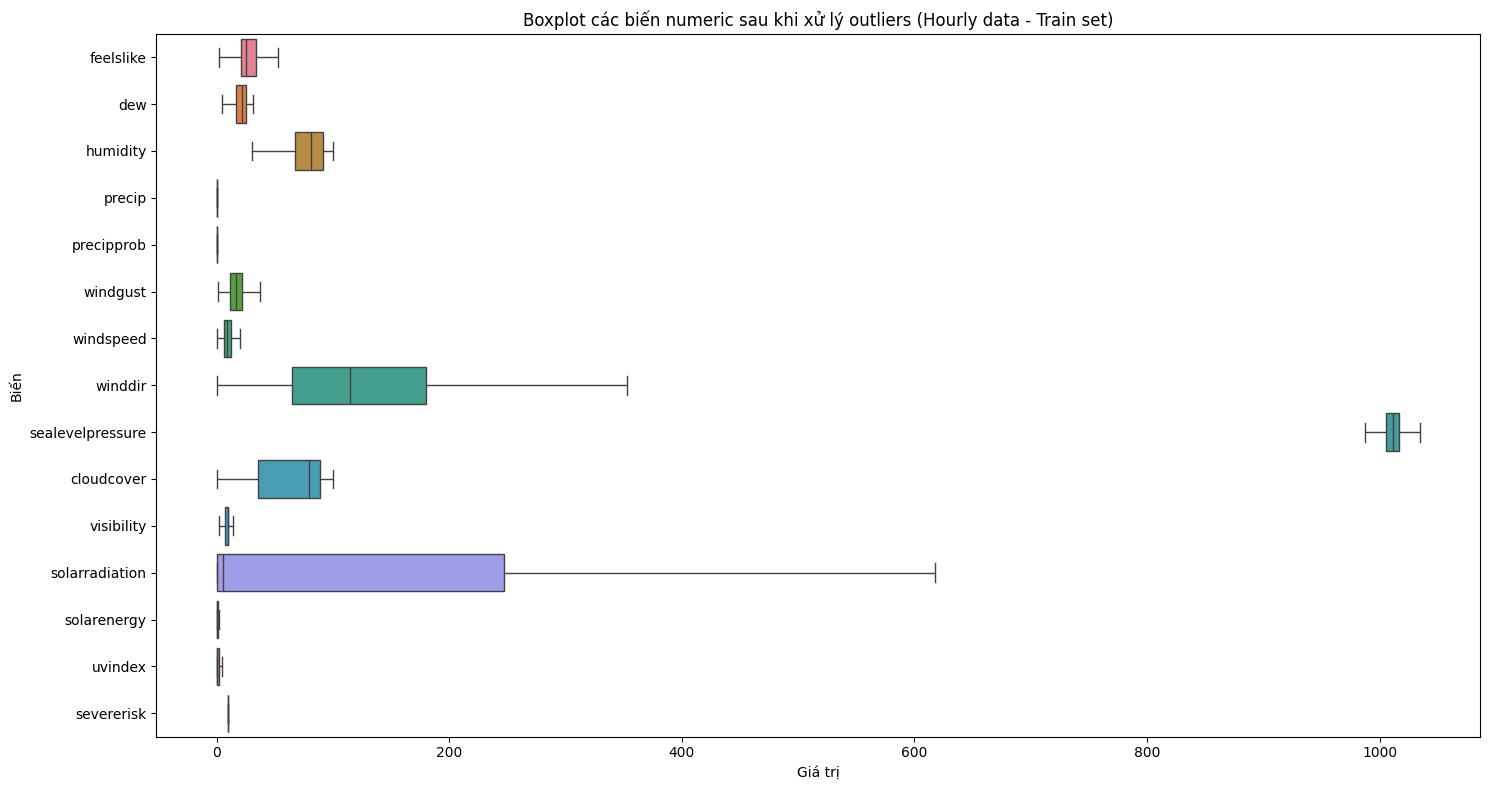

In [86]:
# Chọn toàn bộ cột numeric
numeric_cols = X_train_h_capped.select_dtypes(include=[np.number]).columns

# Vẽ boxplot cho tất cả biến numeric (sau xử lý outliers)
plt.figure(figsize=(15, 8))
sns.boxplot(data=X_train_h_capped[numeric_cols], orient='h', showfliers=False)
plt.title("Boxplot các biến numeric sau khi xử lý outliers (Hourly data - Train set)")
plt.xlabel("Giá trị")
plt.ylabel("Biến")
plt.tight_layout()
plt.show()

In [87]:
# Correlation matric
corr = df_hourly.corr(numeric_only=True)
print(corr)

                      temp  feelslike       dew  humidity    precip  \
temp              1.000000   0.963668  0.793498 -0.195288  0.008059   
feelslike         0.963668   1.000000  0.780998 -0.171755 -0.002804   
dew               0.793498   0.780998  1.000000  0.435492  0.043367   
humidity         -0.195288  -0.171755  0.435492  1.000000  0.061424   
precip            0.008059  -0.002804  0.043367  0.061424  1.000000   
precipprob        0.043853   0.035472  0.086414  0.072175  0.274176   
windgust          0.205252   0.176198  0.053895 -0.218298  0.033686   
windspeed         0.088959   0.088346  0.008403 -0.129585 -0.016352   
winddir           0.074593   0.055246  0.016532 -0.078726  0.022063   
sealevelpressure -0.816868  -0.813780 -0.837978 -0.151234 -0.050082   
cloudcover       -0.119108  -0.120157 -0.000681  0.169233  0.056437   
visibility        0.346025   0.361043  0.067159 -0.422959 -0.002736   
solarradiation    0.448334   0.437110  0.076759 -0.528611 -0.029210   
solare

In [88]:
# Chuẩn hóa

In [89]:
# Xử lý text

In [90]:
# Save the processed data
save_dir = '../data/processed/'

X_train_h_capped.to_excel(save_dir + 'X_train_h.xlsx', index=False)
y_train_h.to_excel(save_dir + 'y_train_h.xlsx', index=False)
X_test_h_capped.to_excel(save_dir + 'X_test_h.xlsx', index=False)
y_test_h.to_excel(save_dir + 'y_test_h.xlsx', index=False)